# Midiendo rendimiento y riesgo con datos históricos

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/7/7d/Copper_Price_History_USD.png" width="600px" height="400px" />

> Ya sabemos que podemos caracterizar la distribución de rendimientos de un activo mediante una medida de tendencia central (media: rendimiento esperado) y una medida de dispersión (desviación estándar: volatilidad). 

> En la clase pasada vimos como obtener reportes históricos de precios de activos. ¿Cómo usamos estos históricos para medir el rendimiento esperado y la volatilidad de los rendimientos?

*Objetivos:*
- Calcular los rendimientos a partir de históricos de precios.
- Estimar rendimiento esperado y riesgo a partir de históricos de rendimientos.
- Anualizar rendimiento y volatilidad cuando los datos están en una base de tiempo menor.
- Verificar la relación entre rendimiento y riesgo a través de datos reales.

**Referencias:**
- http://pandas.pydata.org/
- https://pandas-datareader.readthedocs.io/en/latest/
- Notas del curso "Portfolio Selection and Risk Management", Rice University, disponible en Coursera.
___

## 1. Cálculo de los rendimientos

Muy bien, ya entonces sabemos descargar históricos de precios...

**Ejemplo:** trabajaremos esta clase con activos que se encuentran en el top-10 del índice S&P500. Descargar precios ajustados en el cierre de Microsoft (MSFT), Apple (AAPL), Amazon (AMZN), Facebook (FB) y Alphabet Inc. (GOOGL) desde el primero de enero del 2015 hasta hoy.

In [1]:
# Importar paquetes
import pandas_datareader.data as web
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [3]:
# Información
closes = get_adj_closes(tickers=["MSFT", "AAPL", "AMZN", "FB", "GOOGL"],
                        start_date="2015-01-01")

In [4]:
# Precios diarios ajustados en el cierre
closes.head()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL
Date,,,,,
2015-01-02,41.269203,24.782110,308.519989,78.449997,529.549988
2015-01-05,40.889702,24.083958,302.190002,77.190002,519.460022
2015-01-06,40.289543,24.086227,295.290009,76.150002,506.640015
2015-01-07,40.801434,24.423975,298.420013,76.150002,505.149994
2015-01-08,42.001743,25.362394,300.459991,78.180000,506.910004


In [5]:
closes.tail()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL
Date,,,,,
2021-08-26,299.089996,147.539993,3316.000000,364.380005,2828.810059
2021-08-27,299.720001,148.600006,3349.629883,372.630005,2880.080078
2021-08-30,303.589996,153.119995,3421.570068,380.660004,2891.810059
2021-08-31,301.880005,151.830002,3470.790039,379.380005,2893.949951
2021-09-01,301.829987,152.509995,3479.000000,382.049988,2904.310059


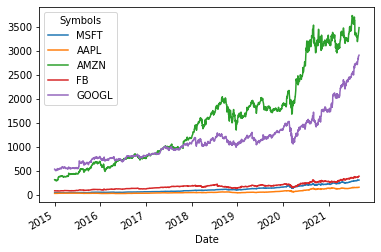

In [7]:
# Gráfico de histórico de precios diarios
closes.plot();

### 1.1. Rendimientos porcentuales

Muy bien, pero para el análisis no trabajamos con los precios sino con los rendimientos... **¿porqué?**

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el el cambio porcentual
$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}
$$
para $t=1,\ldots,n$.

*¡Cuidado!* los rendimientos son de acuerdo a la base de tiempo en que se reportan los precios. Por ejemplo: 
- si los precios se reportan en una base diaria, los rendimientos también son diarios;
- si los precios se reportan en una base mensual, los rendimientos también son mensuales.

In [8]:
closes.pct_change?

In [9]:
(40.889702 - 41.269203) / 41.269203

-0.00919574337309101

In [11]:
# Calcular rendimientos
ret = closes.pct_change().dropna()
ret.head()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL
Date,,,,,
2015-01-05,-0.009196,-0.028172,-0.020517,-0.016061,-0.019054
2015-01-06,-0.014678,0.000094,-0.022833,-0.013473,-0.024679
2015-01-07,0.012705,0.014022,0.010600,0.000000,-0.002941
2015-01-08,0.029418,0.038422,0.006836,0.026658,0.003484
2015-01-09,-0.008405,0.001072,-0.011749,-0.005628,-0.012211


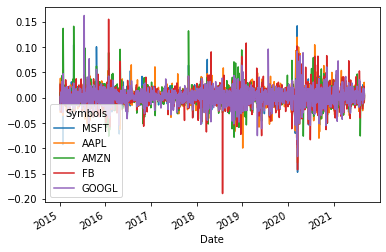

In [12]:
# Graficar...
ret.plot();

**¿Qué se observa respecto a los precios?**

Respuestas:
- Los rendimientos parecen conservar tendecias estadísticas constantes (por ejemplo, oscilan al rededor de números cercanos a cero). 

### 1.2. Rendimientos logarítmicos (log-rendimientos)

Otro rendimiento usado con frecuencia es el rendimiento continuamente compuesto o rendimiento logaritmico. Éste, está definido como

$$
r_t=\ln\left(\frac{S_t}{S_{t-1}}\right).
$$

Es fácil darse cuenta que $r_t=\ln(1+R_t)$.

<font color=blue>Ver en el tablero</font> que si $0\leq|x|\ll 1$, entonces $\ln(1+x)\approx x$.

In [13]:
# ¿Cómo calcular S_{t-1}?
closes.shift?

In [14]:
closes.shift().head()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL
Date,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN
2015-01-05,41.269203,24.782110,308.519989,78.449997,529.549988
2015-01-06,40.889702,24.083958,302.190002,77.190002,519.460022
2015-01-07,40.289543,24.086227,295.290009,76.150002,506.640015
2015-01-08,40.801434,24.423975,298.420013,76.150002,505.149994


In [21]:
closes.head()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL
Date,,,,,
2015-01-02,41.269203,24.782110,308.519989,78.449997,529.549988
2015-01-05,40.889702,24.083958,302.190002,77.190002,519.460022
2015-01-06,40.289543,24.086227,295.290009,76.150002,506.640015
2015-01-07,40.801434,24.423975,298.420013,76.150002,505.149994
2015-01-08,42.001743,25.362394,300.459991,78.180000,506.910004


In [22]:
# Calcular rendimientos continuamente compuestos
log_ret = np.log(closes / closes.shift()).dropna()

In [23]:
log_ret.head()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL
Date,,,,,
2015-01-05,-0.009238,-0.028576,-0.020731,-0.016191,-0.019238
2015-01-06,-0.014786,0.000094,-0.023098,-0.013565,-0.024989
2015-01-07,0.012625,0.013925,0.010544,0.000000,-0.002945
2015-01-08,0.028994,0.037702,0.006813,0.026309,0.003478
2015-01-09,-0.008441,0.001072,-0.011818,-0.005644,-0.012286


In [24]:
# Recordar rendimientos porcentuales. Ver que son similares
ret.head()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL
Date,,,,,
2015-01-05,-0.009196,-0.028172,-0.020517,-0.016061,-0.019054
2015-01-06,-0.014678,0.000094,-0.022833,-0.013473,-0.024679
2015-01-07,0.012705,0.014022,0.010600,0.000000,-0.002941
2015-01-08,0.029418,0.038422,0.006836,0.026658,0.003484
2015-01-09,-0.008405,0.001072,-0.011749,-0.005628,-0.012211


In [25]:
# Veamos el valor absoluto de la diferencia
np.abs(ret - log_ret).head()

Symbols,MSFT,AAPL,AMZN,FB,GOOGL
Date,,,,,
2015-01-05,0.000043,4.044343e-04,0.000213,0.000130,0.000184
2015-01-06,0.000109,4.440594e-09,0.000265,0.000092,0.000310
2015-01-07,0.000080,9.740484e-05,0.000056,0.000000,0.000004
2015-01-08,0.000424,7.197489e-04,0.000023,0.000349,0.000006
2015-01-09,0.000036,5.746169e-07,0.000070,0.000016,0.000075


Por lo anterior, muchas veces se usan para el análisis los rendimientos continuamente compuestos.
___

## 2. Caracterización de la distribución de los rendimientos

Entonces:
- partimos de que tenemos los rendimientos porcentuales diarios de Apple, Walmart, IBM y Nike desde inicios del 2011 a finales del 2015;
- ¿cómo resumirían estos datos?

In [26]:
# Rendimiento medio diario (media aritmética)
ret.mean()

Symbols
MSFT     0.001333
AAPL     0.001254
AMZN     0.001626
FB       0.001143
GOOGL    0.001155
dtype: float64

In [27]:
# Volatilidad diaria (desviación estándar)
ret.std()

Symbols
MSFT     0.017118
AAPL     0.018438
AMZN     0.019146
FB       0.019889
GOOGL    0.016761
dtype: float64

In [28]:
# Podemos resumir en un DataFrame
ret_dist_summary = pd.DataFrame(data={'Rendimiento esperado': ret.mean(),
                                      'Volatilidad': ret.std()})
ret_dist_summary

,Rendimiento esperado,Volatilidad
Symbols,,
MSFT,0.001333,0.017118
AAPL,0.001254,0.018438
AMZN,0.001626,0.019146
FB,0.001143,0.019889
GOOGL,0.001155,0.016761


Normalmente se reportan rendimientos esperados y volatilidades en una base anual. Para anualizar:

$$E[r_a]=12E[r_m]=252E[r_d]=52E[r_w],\text{ y}$$

$$\sigma_{r_a}=\sqrt{12}\sigma_{r_m}=\sqrt{252}\sigma_{r_d}=\sqrt{52}\sigma_{r_w}$$

In [29]:
# Resumen en base anual
ret_dist_summary_annual = pd.DataFrame(data={'Rendimiento esperado': 252 * ret.mean(),
                                             'Volatilidad': np.sqrt(252) * ret.std()})

In [30]:
ret_dist_summary_annual

,Rendimiento esperado,Volatilidad
Symbols,,
MSFT,0.335869,0.271735
AAPL,0.315897,0.292688
AMZN,0.409850,0.303927
FB,0.287946,0.315730
GOOGL,0.290943,0.266072


In [31]:
from matplotlib import pyplot as plt

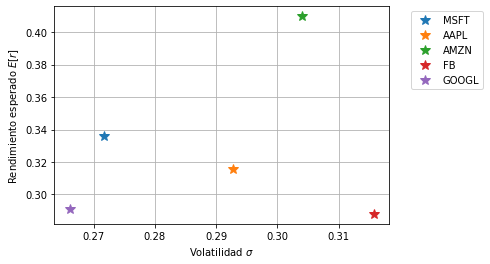

In [32]:
# Gráfico rendimiento esperado vs. volatilidad
plt.figure(figsize=(6, 4))
for i in range(len(ret_dist_summary_annual)):
    plt.plot(ret_dist_summary_annual.iloc[i, 1],
             ret_dist_summary_annual.iloc[i, 0],
             '*',
             label=ret_dist_summary_annual.index[i],
             ms=10)

plt.grid()
plt.xlabel("Volatilidad $\sigma$")
plt.ylabel("Rendimiento esperado $E[r]$")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))

### 2.1 Ajuste de curvas con mínimos cuadrados
Consideramos que tenemos un conjunto de n pares ordenados de datos $(\sigma_{r_i},E[r_i])$, para $i=1,2,3,\dots,n$... **en este caso corresponden a volatilidad y rendimiento esperado**

#### ¿Cuál es la recta que mejor se ajusta a estos datos?
Consideramos entonces ajustes de la forma $\hat{f}(\sigma) = \beta_0+\beta_1 \sigma = \left[1 \quad \sigma\right]\left[\begin{array}{c} \beta_0 \\ \beta_1 \end{array}\right]=\left[1 \quad \sigma\right]\boldsymbol{\beta}$ (lineas rectas).

Para decir '*mejor*', tenemos que definir algún sentido en que una recta se ajuste *mejor* que otra.

**Mínimos cuadrados**: el objetivo es seleccionar los coeficientes $\boldsymbol{\beta}=\left[\beta_0 \quad \beta_1 \right]^T$, de forma que la función evaluada en los puntos $\sigma_{r_i}$ ($\hat{f}(\sigma_{r_i})$) aproxime los valores correspondientes $E[r_i]$.

La formulación por mínimos cuadrados, encuentra los $\boldsymbol{\beta}=\left[\beta_0 \quad \beta_1 \right]^T$ que minimiza
$$\sum_{i=1}^{n}(E[r_i]-\hat{f}(\sigma_{r_i}))^2$$

In [33]:
# Importar el módulo optimize de la librería scipy
from scipy.optimize import minimize

In [38]:
# Funcion minimize
minimize?

In [37]:
# Funcion objetivo y condicion inicial
def min_sq(beta, y, x):
    recta = beta[0] + beta[1] * x
    error = y - recta
    return (error**2).sum()
beta_ini = [0, 0]

In [39]:
# Resolver problema de optimizacion
sol = minimize(fun=min_sq,
               x0=beta_ini,
               args=(ret_dist_summary_annual["Rendimiento esperado"], ret_dist_summary_annual["Volatilidad"]))

In [40]:
sol

      fun: 0.009505573496504353
 hess_inv: array([[ 23.8701762 , -81.95744907],
       [-81.95744907, 282.58197997]])
      jac: array([ 1.16415322e-10, -8.14907253e-10])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 4
     njev: 9
   status: 0
  success: True
        x: array([0.19373223, 0.46329152])

In [41]:
beta = sol.x
beta

array([0.19373223, 0.46329152])

In [47]:
X = np.concatenate((np.ones((5, 1)), ret_dist_summary_annual["Volatilidad"].values.reshape((5, 1))), axis=1)
y = ret_dist_summary_annual["Rendimiento esperado"].values
X, y

(array([[1.        , 0.27173505],
        [1.        , 0.2926884 ],
        [1.        , 0.30392731],
        [1.        , 0.31573049],
        [1.        , 0.26607225]]),
 array([0.33586895, 0.31589728, 0.40985007, 0.28794555, 0.29094314]))

In [48]:
np.linalg.inv((X.T.dot(X))).dot(X.T).dot(y)

array([0.19373346, 0.46328729])

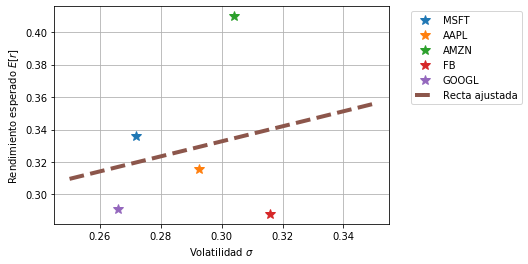

In [51]:
# Gráfico rendimiento esperado vs. volatilidad
plt.figure(figsize=(6, 4))
for i in range(len(ret_dist_summary_annual)):
    plt.plot(ret_dist_summary_annual.iloc[i, 1],
             ret_dist_summary_annual.iloc[i, 0],
             '*',
             label=ret_dist_summary_annual.index[i],
             ms=10)

s = np.linspace(0.25, 0.35)
plt.plot(s, beta[0] + beta[1] * s, '--', label="Recta ajustada", lw=4)

plt.grid()
plt.xlabel("Volatilidad $\sigma$")
plt.ylabel("Rendimiento esperado $E[r]$")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))

In [49]:
beta

array([0.19373223, 0.46329152])

**¿Qué se puede concluir acerca de la relación entre riesgo (medido con la volatilidad) y el rendimiento esperado (medido con la media)?**

Respuestas:
- La pendiente de la recta es positiva, lo que confirma la relación positiva entre rendimiento esperado y riesgo.
- Si el mercado solo estuviera dado por los cinco activos analizados, la tasa libre de riesgo sería $19.37\%$.
- Por cada unidad de riesgo (volatilidad), el rendimiento aumenta $46.3\%$.

## 3. Comentarios finales acerca del uso de datos históricos.

### ¡Cuidado!
- Es cierto que los patrones que vemos sobre periodos largos de tiempo en diferentes tipos de intrumentos son muy robustos en términos de la relación rendimiento/riesgo (positiva).
- Por tanto, esperamos rendimientos más altos en el futuro cuando asumimos cierto riesgo.
- ¿Cómo encontramos ese 'rendimiento esperado'? Datos históricos (humanos: tendencia a generalizar)

- Entonces, la idea es que si los rendimientos esperados son un p.e. estacionario, el promedio de muchos rendimientos pasados es una buena estimación del rendimiento esperado futuro (Teorema del límite central).
- ¿Deberíamos pensarlo dos veces?

## SI

Problemas:
- La muestra de datos en el periodo específico de tiempo puede estar sesgada.
- Ventanas de tiempo más grandes reducen especificidad de la muestra y estimados más precisos.
 - Aún así, datos muy viejos pueden ser no representativos.
- Nuevos fondos o estrategias de inversión están a menudo sesgados positivamente:
 - reporte de resultados en tiempos voluntarios;
 - las que mueren (no funcionan), no se reportan;

# Anuncios parroquiales:
## 1. Fin Módulo 1. Revisar que se hayan cumplido los objetivos del módulo (Clase0)
## 2. Tarea: revisar archivo "Tarea3_MidiendoRendimientoRiesgo" en clase. 
## 3. Recordar quiz la siguiente clase.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>